# Coconut Price Forecasting (1996–2023)

### Table of Contents
1. [Introduction](#intro)  
2. [Setup & Metrics](#setup)  
3. [Data Loading & Preprocessing](#data)  
4. [Exploratory Data Analysis (EDA)](#eda)  
   - [Summary Statistics](#summary)  
   - [Time Series Plot](#timeseries)  
   - [Seasonal Decomposition](#decompose)  
   - [Correlation Heatmap](#heatmap)  
   - [ACF & PACF](#acf)  
5. [Train/Test Split](#split)  
6. [Modeling & Forecasts](#modeling)  
   - [ARIMA / SARIMA](#arimas)  
   - [ARIMAX / SARIMAX](#arimax)  
   - [XGBoost](#xgb)  
   - [Temporal Fusion Transformer](#tft)  
7. [Performance Comparison](#performance)  
8. [Conclusions](#conclusions)

<a id="intro"></a>
## 1. Introduction

This notebook implements and compares multiple forecasting models on Sri Lankan coconut price data (Jan 1996 – Dec 2023).  We evaluate classical (ARIMA/SARIMA/ARIMAX/SARIMAX), machine‐learning (XGBoost), and deep‐learning (Temporal Fusion Transformer) approaches using MAE, RMSE, MAPE, and sMAPE.

In [1]:
# 2. Setup & Metric Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# Plot styling
plt.style.use('ggplot')
sns.set_palette('mako')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def calculate_metrics(y_true, y_pred):
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    return mae, rmse, mape, smape


In [2]:
# 3. Load & Preprocess Data
df = pd.read_csv('Final_Coconut_Dataset.csv', parse_dates=['date'])
df = (
    df[df.date < '2024-01-01']
      .set_index('date')
      .sort_index()
)
print(f"Dataset spans {df.index.min().date()} to {df.index.max().date()}")
df.head()

Dataset spans 1996-01-01 to 2023-12-01


,retail_price_lkr,kurunegala_producer_price_lkr,puttalam_producer_price_lkr,gampaha_producer_price_lkr,exchange_rate_usd_to_lkr,fuel_price_lad
date,,,,,,
1996-01-01,7.53,5.721,5.71179,5.702463,53.69,12.4
1996-02-01,8.33,6.034,6.02479,6.015463,53.69,12.4
1996-03-01,8.93,5.640,5.63079,5.621463,53.69,12.4
1996-04-01,9.25,5.583,5.57379,5.564463,54.74,12.4
1996-05-01,9.25,6.205,6.19579,6.186463,54.95,12.4


## 4. Exploratory Data Analysis (EDA)  <a id="eda"></a>

In [3]:
# 4.1 Summary Statistics
stats = df.describe().T
stats['range'] = stats['max'] - stats['min']
stats['cv(%)'] = (stats['std'] / stats['mean']) * 100
stats = stats[['count','min','max','range','mean','std','cv(%)','25%','50%','75%']].round(2)
stats

,count,min,max,range,mean,std,cv(%),25%,50%,75%
retail_price_lkr,336.0,7.53,93.82,86.29,33.66,23.29,69.19,13.77,28.05,46.20
kurunegala_producer_price_lkr,336.0,3.52,71.79,68.26,25.15,18.19,72.33,8.81,21.65,35.21
puttalam_producer_price_lkr,336.0,3.52,71.78,68.26,25.14,18.19,72.36,8.80,21.64,35.20
gampaha_producer_price_lkr,336.0,3.51,71.77,68.26,25.13,18.19,72.39,8.79,21.64,35.20
exchange_rate_usd_to_lkr,336.0,53.69,368.50,314.81,131.36,66.38,50.54,96.27,112.72,149.69
fuel_price_lad,336.0,12.40,460.00,447.60,86.96,84.49,97.17,30.00,75.00,104.00


/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


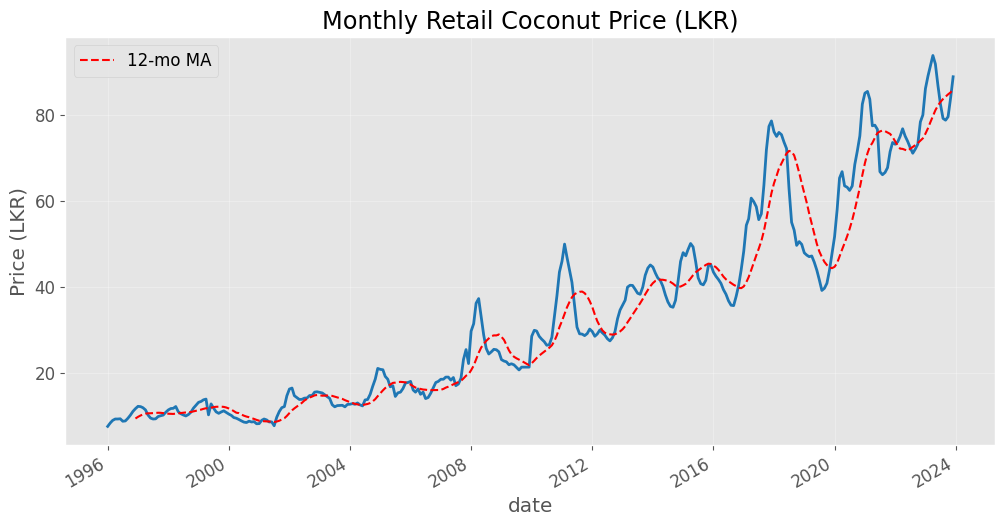

In [4]:
# 4.2 Time Series Plot
plt.plot(df.index, df['retail_price_lkr'], color='#1f77b4', lw=2)
plt.title('Monthly Retail Coconut Price (LKR)')
plt.xlabel('Date'); plt.ylabel('Price (LKR)')
plt.grid(alpha=0.3)
# 12-month moving average
df['retail_price_lkr'].rolling(12).mean().plot(lw=1.5, ls='--', color='r', label='12-mo MA')
plt.legend(); plt.show()

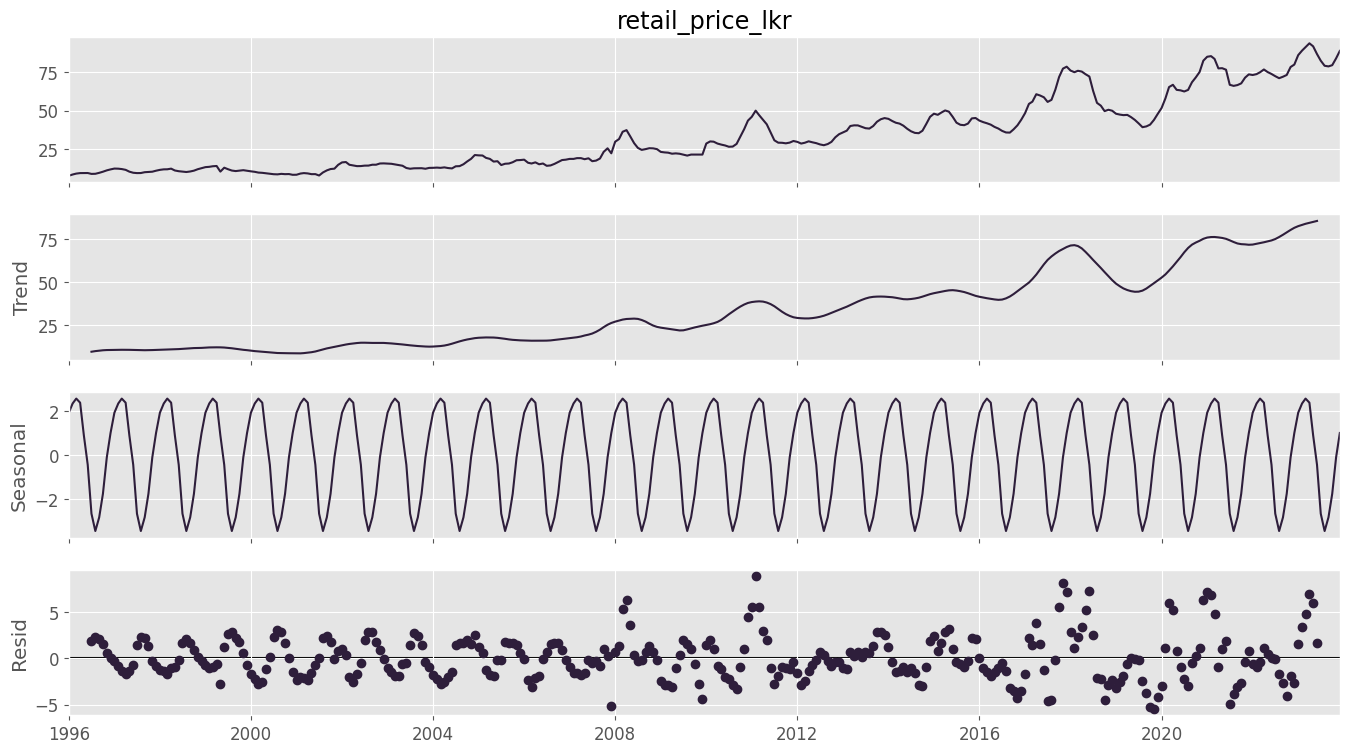

In [5]:
# 4.3 Seasonal Decomposition
dec = seasonal_decompose(df['retail_price_lkr'], model='additive', period=12)
fig = dec.plot()
fig.set_size_inches(14,8)


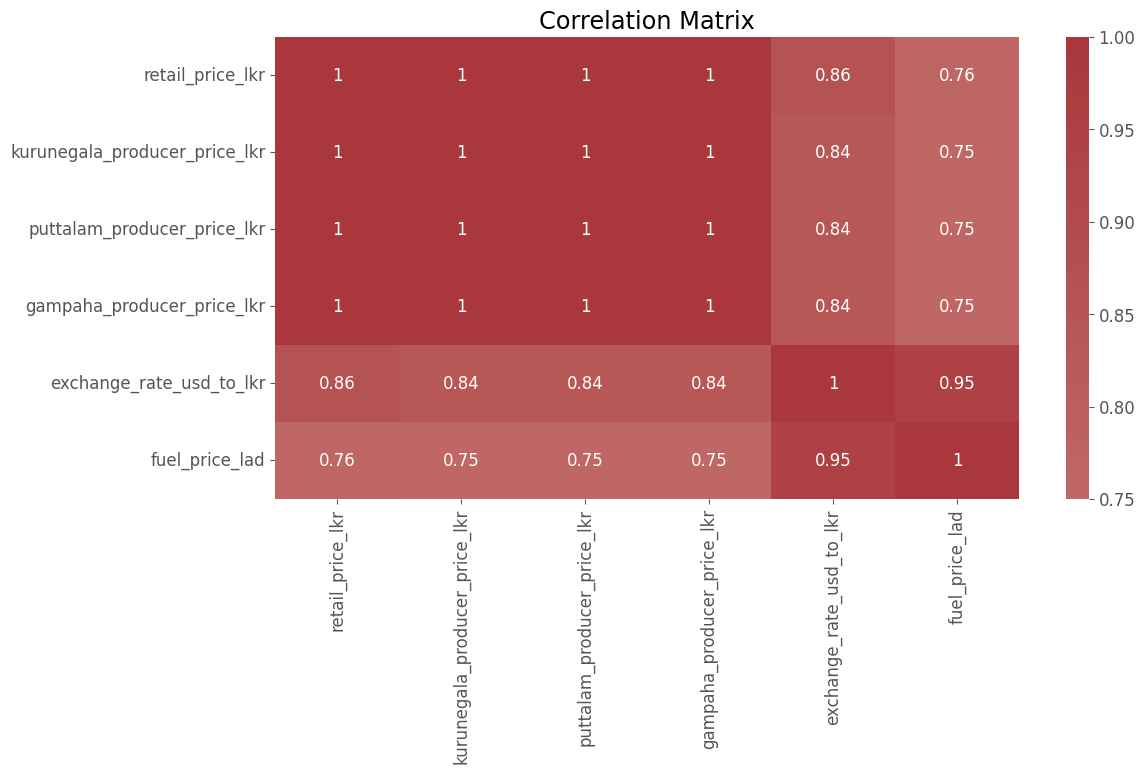

In [6]:
# 4.4 Correlation Heatmap
corr = df.corr().round(2)
sns.heatmap(corr, annot=True, cmap='vlag', center=0)
plt.title('Correlation Matrix'); plt.show()

Text(0.5, 1.0, 'PACF')

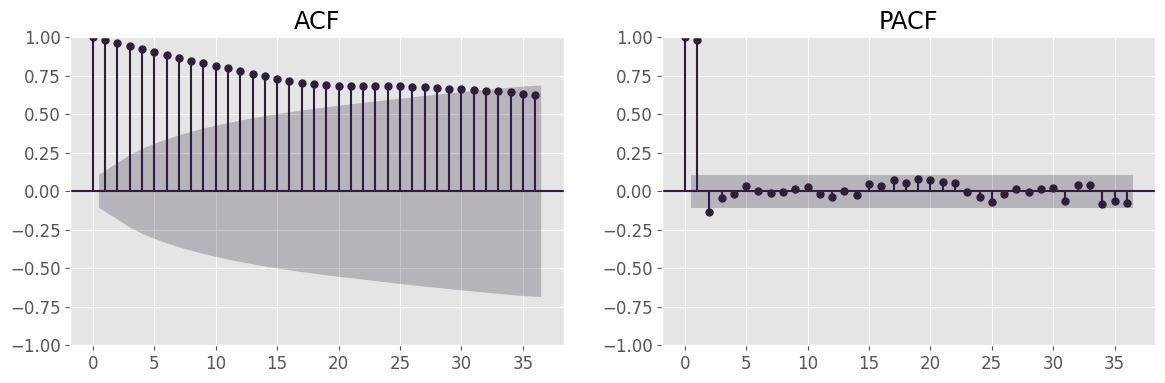

In [7]:
# 4.5 ACF & PACF
fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(df['retail_price_lkr'], lags=36, ax=axes[0]); axes[0].set_title('ACF')
plot_pacf(df['retail_price_lkr'], lags=36, ax=axes[1]); axes[1].set_title('PACF')


## 5. Train/Test Split  <a id="split"></a>

In [8]:
prices = df['retail_price_lkr']
exogs  = df[['kurunegala_producer_price_lkr','puttalam_producer_price_lkr','exchange_rate_usd_to_lkr','fuel_price_lad']]
train_y, test_y = prices[:-12], prices[-12:]
train_x, test_x = exogs[:-12],  exogs[-12:]
print(f"Train: {train_y.index[0].date()}→{train_y.index[-1].date()}")
print(f"Test : {test_y.index[0].date()}→{test_y.index[-1].date()}")

Train: 1996-01-01→2022-12-01
Test : 2023-01-01→2023-12-01


## 6. Modeling & Forecasts  <a id="modeling"></a>
- ARIMA / SARIMA  <a id="arimas"></a>
- ARIMAX / SARIMAX  <a id="arimax"></a>
- XGBoost  <a id="xgb"></a>
- Temporal Fusion Transformer  <a id="tft"></a>

In [9]:
# 6.1 Helper to fit and forecast
def forecast_model(name):
    if name=='ARIMA':
        m = ARIMA(train_y, order=(5,1,0)).fit()
        return m.forecast(12)
    if name=='SARIMA':
        m = SARIMAX(train_y, order=(5,1,0), seasonal_order=(1,1,1,12)).fit(disp=False)
        return m.forecast(12)
    if name=='ARIMAX':
        m = ARIMA(train_y, order=(5,1,0), exog=train_x).fit()
        return m.forecast(12, exog=test_x)
    if name=='SARIMAX':
        m = SARIMAX(train_y, order=(5,1,0), seasonal_order=(1,1,1,12), exog=train_x)
        m = m.fit(disp=False)
        return m.forecast(12, exog=test_x)
    if name=='XGBoost':
        # prepare lags
        lags=12
        def lag(df,c): return pd.concat([df[c].shift(i).rename(f'{c}_lag{i}') for i in range(1,lags+1)],axis=1)
        L = pd.concat([lag(df,'retail_price_lkr')] + [lag(df,c) for c in exogs.columns],axis=1).dropna()
        Xtr, Xte = L.iloc[:-12], L.iloc[-12:]
        ytr = df['retail_price_lkr'].iloc[lags:-12]
        xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100,
                           learning_rate=0.05, max_depth=6,
                           subsample=0.8, colsample_bytree=0.9)
        xgb.fit(Xtr, ytr)
        return pd.Series(xgb.predict(Xte), index=test_y.index)
    raise ValueError(name)

# run forecasts
models = ['ARIMA','SARIMA','ARIMAX','SARIMAX','XGBoost']
preds = {m: forecast_model(m) for m in models}
# add TFT manually
tft_vals = [83.9850,86.6156,88.3896,88.7184,86.5828,82.1769,77.9369,75.5659,76.3885,80.4487,84.7031,88.4693]
preds['TFT'] = pd.Series(tft_vals, index=test_y.index)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

In [13]:
# 7. Performance Comparison
results   = pd.DataFrame({'Actual': test_y, **preds})
metrics   = {m: calculate_metrics(results['Actual'], results[m]) for m in preds}
metrics_df = pd.DataFrame(metrics, index=['MAE','RMSE','MAPE','sMAPE']).T

# Sort by highest RMSE first
metrics_df = metrics_df.sort_values(by='RMSE', ascending=True)

# Highlight the best (minimum) value in each column
metrics_df.style\
          .highlight_min(color='lightgreen', axis=0)\
          .format({
              'MAE': '{:.3f}',
              'RMSE': '{:.3f}',
              'MAPE': '{:.2f}%',
              'sMAPE': '{:.2f}%'
          })


,MAE,RMSE,MAPE,sMAPE
TFT,2.918,3.354,3.37%,3.44%
SARIMAX,4.797,5.009,5.52%,5.69%
ARIMAX,4.800,5.440,5.44%,5.63%
SARIMA,6.409,7.005,7.31%,7.64%
ARIMA,6.255,7.726,6.99%,7.38%
XGBoost,12.616,12.957,14.60%,15.80%


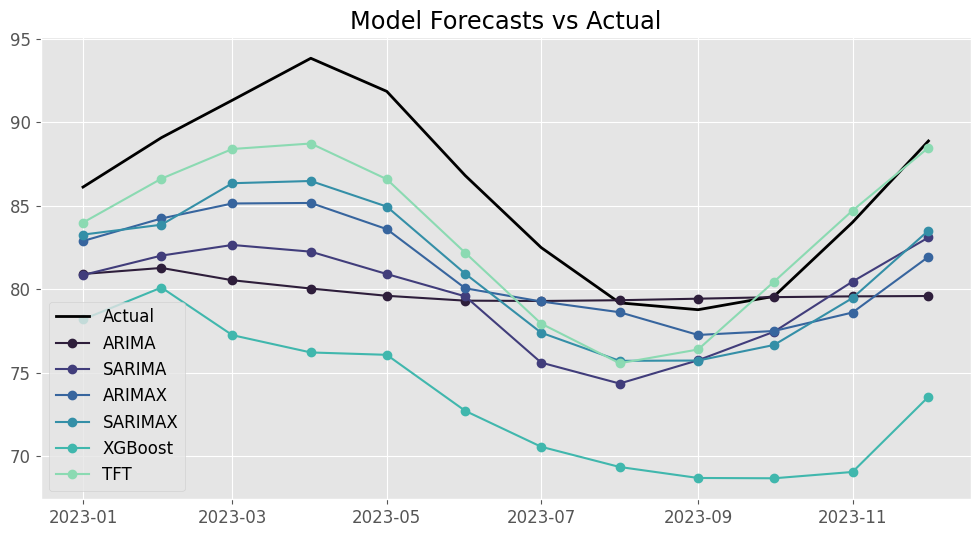

In [11]:
# Combined Forecast Plot
plt.plot(results['Actual'], 'k-', lw=2, label='Actual')
for m in preds:
    plt.plot(results[m], marker='o', label=m)
plt.title('Model Forecasts vs Actual')
plt.legend(); plt.show()

## 8. Conclusions  <a id="conclusions"></a>

- **Top performer** (by MAE & RMSE): **TFT**  
- Including exogenous drivers (ARIMAX/SARIMAX) improves over uni-variate.  